In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [102]:
def preprocess():
    image = cv2.imread("yann_lecun.jpg")
    image  = cv2.resize(image, (600 , 600))
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    return image

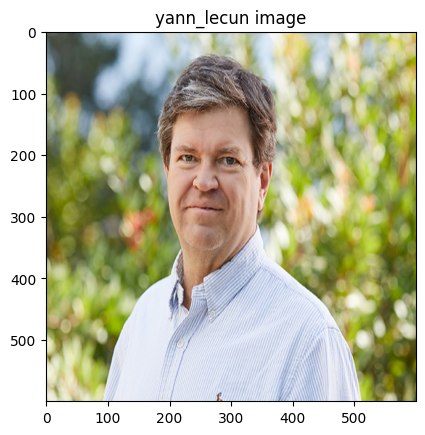

In [103]:
image = preprocess()
plt.imshow(image)
plt.title("yann_lecun image")
plt.show()

In [104]:
import numpy as np
import cv2

def apply_convolution(image, kernels, stride=(1, 1), padding='valid'):
    (img_height, img_width, img_channels) = image.shape
    (k_height, k_width) = kernels.shape
    
    if padding == 'same':
        pad_h = ((img_height - 1) * stride[0] + k_height - img_height) // 2
        pad_w = ((img_width - 1) * stride[1] + k_width - img_width) // 2
        image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
    else:
        pad_h = pad_w = 0

    output_height = (img_height + (2 * pad_h) - k_height) // stride[0] + 1
    output_width = (img_width + (2 * pad_w )- k_width) // stride[1] + 1
   
    output_image = np.zeros((output_height, output_width))

    for y in range(output_height):
        for x in range(output_width):
            for c in range(img_channels):
                region = image[y * stride[0] : y * stride[0] + k_height, x * stride[1] : x * stride[1] + k_width, c]
                output_image[y, x] += np.sum(region * kernels[:, :])

    return output_image



In [105]:
def max_pooling(image, size, stride):
    img_height, img_width, img_channels = image.shape
    pool_height, pool_width = size 

    pooled_height = (img_height - pool_height) // stride + 1
    pooled_width = (img_width - pool_width) // stride + 1
    pooled_image = np.zeros((pooled_height, pooled_width, img_channels))

    for y in range(pooled_height):
        for x in range(pooled_width):
            for c in range(img_channels):
                region = image[y * stride : y * stride + pool_height, x * stride : x * stride + pool_width , c]
                pooled_image[y, x, c] = np.max(region)

    return pooled_image

In [106]:
vertical_edge_kernel = np.array([
    [1,0,-1],
    [1,0,-1],
    [1,0,-1]
])
horizontal_edge_kernel = np.array([
    [1,1,1],
    [0,0,0],
    [-1,-1,-1]
])
edge_enhancement_kernel = np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1],
])

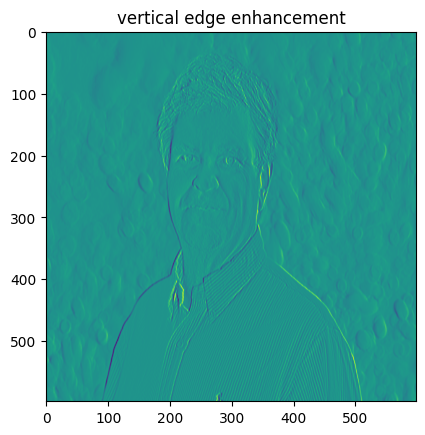

In [107]:
image_vertical_edge = apply_convolution(image , vertical_edge_kernel)
plt.imshow(image_vertical_edge)
plt.title("vertical edge enhancement")
plt.show()

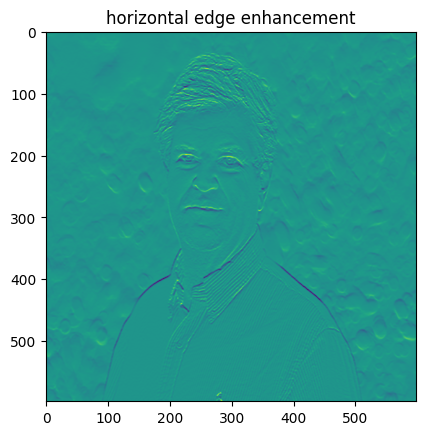

In [108]:
image_horizontal_edge = apply_convolution(image , horizontal_edge_kernel)
plt.imshow(image_horizontal_edge )
plt.title("horizontal edge enhancement")
plt.show()

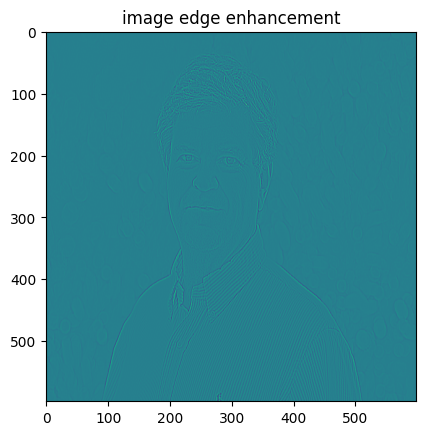

In [109]:
image_edge_enhancement = apply_convolution(image , edge_enhancement_kernel)
plt.imshow(image_edge_enhancement)
plt.title("image edge enhancement")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


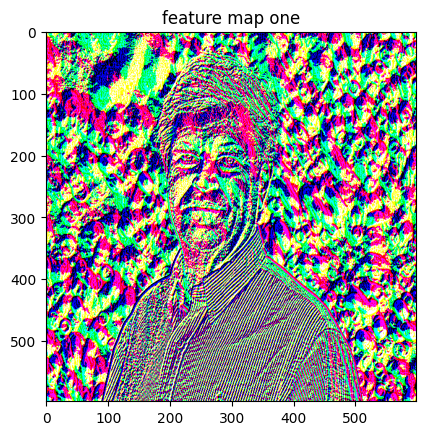

In [110]:
feature_map_one = np.stack((image_vertical_edge , image_horizontal_edge , image_edge_enhancement) , axis = -1)
plt.imshow(feature_map_one)
plt.title("feature map one")
plt.show()

In [111]:
gaussian_blur_filter = np.array([
    [1,4,7,4,1],
    [4,16,26,16,4],
    [7,26,41,26,7],
    [4,16,26,16,4],
    [1,4,7,4,1],
])
large_edge_enhancement_filter = np.array([
    [0,0,-1,0,0],
    [0,0,-1,0,0],
    [-1,-1,8,-1,-1],
    [0,0,-1,0,0],
    [0,0,-1,0,0]
])

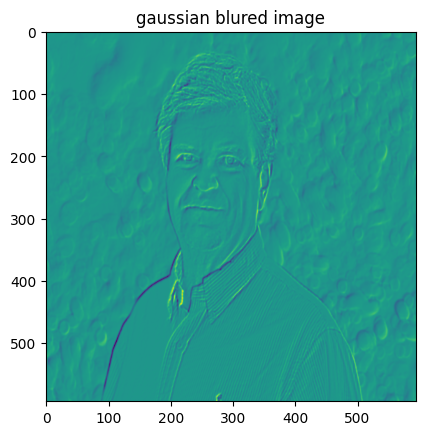

In [112]:
gaussian_image = apply_convolution(feature_map_one , gaussian_blur_filter )
plt.imshow(gaussian_image)
plt.title("gaussian blured image")
plt.show()

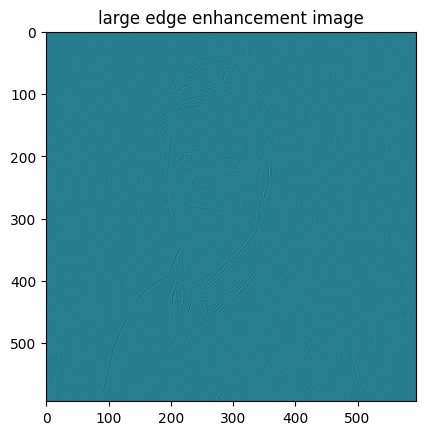

In [113]:
large_edge_enhancement_image = apply_convolution(feature_map_one , large_edge_enhancement_filter)
plt.imshow(large_edge_enhancement_image)
plt.title("large edge enhancement image")
plt.show()

In [114]:
feature_map_two = np.stack((gaussian_image , large_edge_enhancement_image) , axis = -1)

In [115]:
maxpooled_image = max_pooling(feature_map_two , (2,2) , 2)


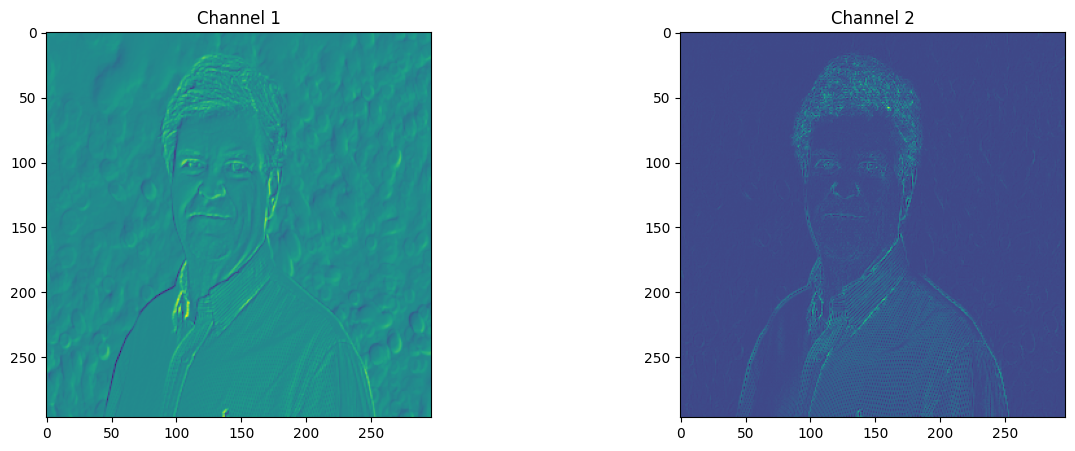

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
titles = ['Channel 1', 'Channel 2']

for i in range(2):
    axs[i].imshow(maxpooled_image[:, :, i])
    axs[i].set_title(titles[i])

extra point part:

In [117]:
image = cv2.imread("yann_lecun.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (600, 600))

In [118]:

fourier_image = np.fft.fft2(image)
fourier_shift = np.fft.fftshift(fourier_image)
magnitude_spec = 20 * np.log(np.abs(fourier_shift))
phase_spec = np.angle(fourier_shift)

In [119]:
def laplacian(image):
    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])

    laplacian_img = np.zeros_like(image, dtype=float)
    padded_image = np.pad(image, 1, mode='constant', constant_values=0)
   
    for i in range(padded_image.shape[0]-2):
        for j in range(padded_image.shape[1]-2):
            region = padded_image[i:i+3, j:j+3]
            laplacian_img[i, j] = np.sum(laplacian_kernel * region)


    return laplacian_img

In [120]:
# creating mask filters
def filter(shape, type='lowpass', radius=30, band_width=10):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)

    if type == 'lowpass':
        mask[(rows // 2) -radius : (rows // 2)+radius , (cols // 2)-radius : (cols // 2) +radius] = 1
    elif type == 'highpass':
        mask[:,:] = 1
        mask[(rows // 2)-radius:(rows // 2)+radius, (cols // 2) -radius: (cols // 2) + radius] = 0
    elif type == 'bandpass':
        mask[:,:] = 1
        mask[(rows // 2) - radius - band_width : (rows // 2) + radius + band_width , (cols // 2) - radius - band_width : (cols // 2) + radius + band_width] = 0
        mask[(rows // 2) - radius : (rows // 2) + radius , (cols // 2) - radius : (cols // 2) + radius] = 1
    return mask

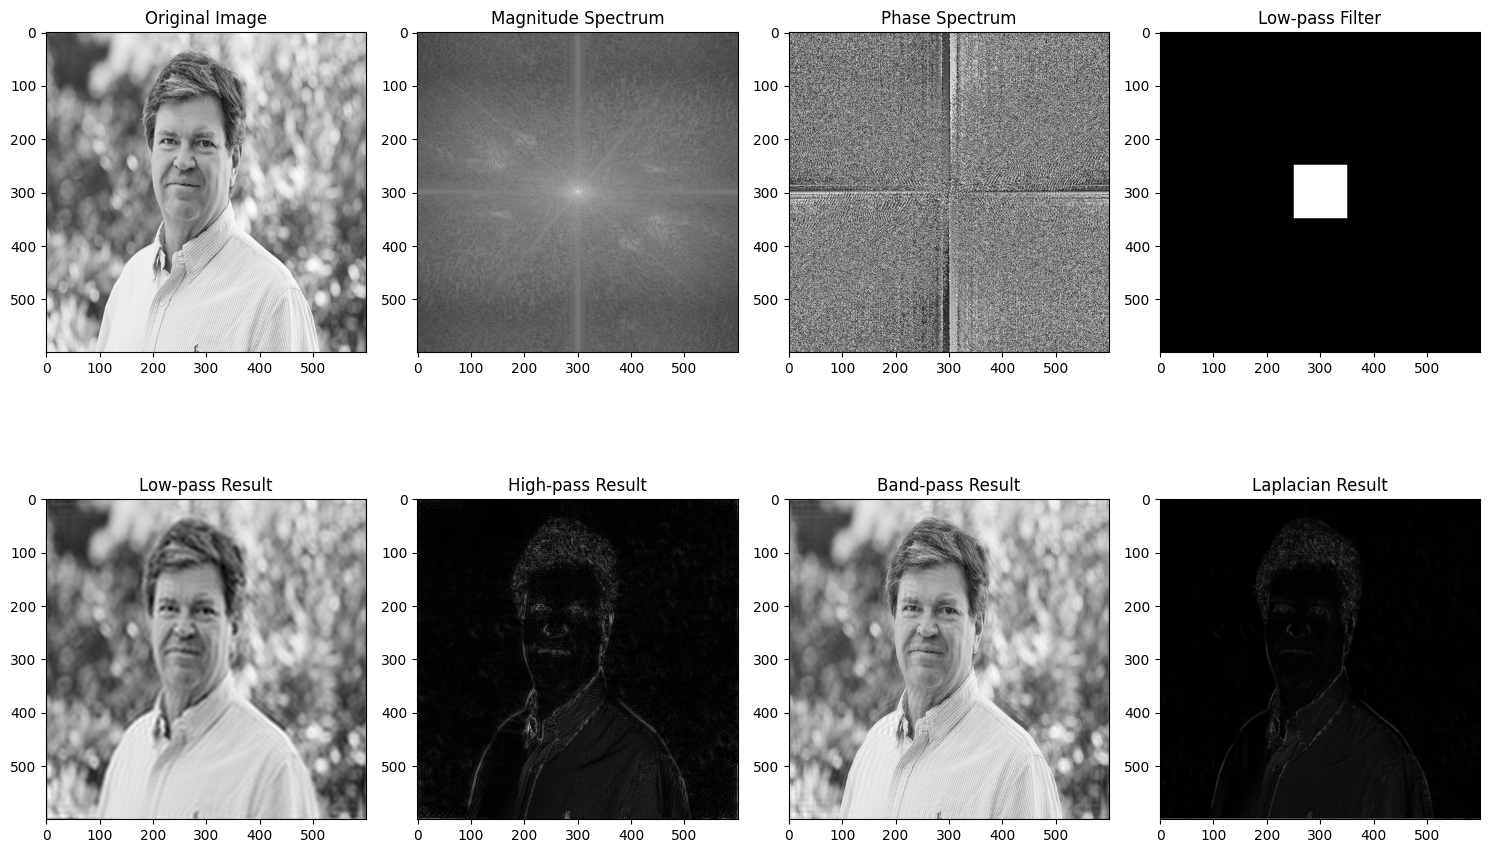

In [121]:
# Create filters
lowpass_mask = filter(image.shape, 'lowpass', 50)
highpass_mask = filter(image.shape, 'highpass', 50)
bandpass_mask = filter(image.shape, 'bandpass', 50, 10)

# masking
lowpass_fourier_shift = fourier_shift * lowpass_mask
highpass_fourier_shift = fourier_shift * highpass_mask
bandpass_fourier_shift = fourier_shift * bandpass_mask

# inverse FFT 
lowpass_image = np.fft.ifft2(np.fft.ifftshift(lowpass_fourier_shift))
lowpass_image = np.abs(lowpass_image)

highpass_image = np.fft.ifft2(np.fft.ifftshift(highpass_fourier_shift))
highpass_image = np.abs(highpass_image)

bandpass_image = np.fft.ifft2(np.fft.ifftshift(bandpass_fourier_shift))
bandpass_image = np.abs(bandpass_image)

#  laplacian
laplacian_image = laplacian(image)
laplacian_image = np.abs(laplacian_image)

plt.figure(figsize=(15, 10))

titles = ['Original Image' , 'Magnitude Spectrum' , 'Phase Spectrum' , 'Low-pass Filter' , 'Low-pass Result' , 
          'High-pass Result' , 'Band-pass Result' , 'Laplacian Result']
images = [image , magnitude_spec , phase_spec , np.log1p(np.abs(lowpass_mask)) , lowpass_image , 
          highpass_image , bandpass_image , laplacian_image]

for i in range (1,9):
    plt.subplot(2,4,i)
    plt.title(titles[i-1])
    plt.imshow(images[i-1] , cmap = "grey")

plt.tight_layout()
plt.show()
